In [1]:
# The MIT License (MIT)

# Copyright (c) 2020 NVIDIA CORPORATION.

# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in
# the Software without restriction, including without limitation the rights to
# use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
# the Software, and to permit persons to whom the Software is furnished to do so,
# subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
# FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
# COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
# IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# ignore this (just for development)
import sys
sys.path.append("..")

In [2]:
import cuAugment

In [3]:
dir(cuAugment)

['Augmenter',
 'Timer',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'augmenter',
 'cuAugment',
 'distributions',
 'templates',
 'timer',
 'transformations']

In [4]:
import numpy as np
import numba

@numba.jit
def checkerboard(dimB=1, dimC=3, dimX=128, dimY=128, dimZ=128, dimT=32, widthX=32, widthY=32, widthZ=32, dtype=np.float32):
    """create a 3D checkerboard in channels_last order"""
    
    result = np.empty((dimB, dimX, dimY, dimZ, dimT, dimC), dtype=dtype)
    
    for b in range(dimB):
        for c in range(dimC):
            for x in range(dimX):
                for y in range(dimY):
                    for z in range(dimZ):
                        for t in range(dimT):
                            value = (x//widthX+y//widthY+z//widthZ + b + c) % 2
                            result[b, x, y, z, t, c] = value*(3+np.cos(t/dimT*8*np.pi))/4.0
    return result

# sample a 3D checkerboard that modifies color over time
with cuAugment.Timer("create checkerboard on CPU"):
    X_cpu = checkerboard()

STATUS: elapsed time 620 ms (create checkerboard on CPU)


In [5]:
from numba import cuda

# output batch of same batch_size, same resolution and same channel order
Y_cpu = np.empty((  X_cpu.shape[0],
                    X_cpu.shape[1],
                    X_cpu.shape[2], 
                    X_cpu.shape[3], 
                    X_cpu.shape[4],
                    X_cpu.shape[5]), dtype=X_cpu.dtype)

# let us work exclusively on the GPU
X = cuda.to_device(X_cpu)
Y = cuda.to_device(Y_cpu)

print("shape of X", X.shape)
print("shape of Y", Y.shape)

shape of X (1, 128, 128, 128, 32, 3)
shape of Y (1, 128, 128, 128, 32, 3)


In [6]:
# define the augmentor in 4D, 
# channels_last as input and channels_last as output format

from cuAugment.transformations import *
from cuAugment.distributions import *

jitaug = cuAugment.Augmenter(dim=4, channel_mode='CL2CL')

# change [0, 1] x [0, 1] x [0, 1] x [0,1] coordinates to [-1, +1] x [-1, +1] x [-1, +1] x [-1, +1]
jitaug.add_spatial_op(CenterXYZT())

# add local deformations, a random rotation over time, and a static scaling
jitaug.add_spatial_op(DeformXYZ(UniformDistribution(-0.3, 0.3)))
jitaug.add_spatial_op(RotateXYZOverTime(UniformDistribution(-0.5, 0.5)))
jitaug.add_spatial_op(ScaleXYZ(DiracDistribution(np.array([0.4]))))

# go back to [0, 1] x [0, 1] x [0, 1] x [0, 1] coordinates
jitaug.add_spatial_op(UncenterXYZT())

# add a color space augmentations
jitaug.add_color_op(InvertColor01(BernoulliDistribution(1.0)))

# now compile the source code
jitaug.compile(verbose=True)

STATUS: augmentor code generated in module_27209898003400332574.py


In [7]:
# excecute the augmentation a few times
# (first run slower due to JIT overhead)

num_repeats = 4  # set > 1 to measure without jit overhead
seed = 3050      # seed = None results in random seeds each augmentation
verbose = True   # provide additional info if input batch_size != output batch_size

# define the value per color channel if interpolation exceeds input domain
empty_values = np.array([0.0, 0.0, 1.0])

# repeat augmentation a few times
for _ in range(num_repeats):
    with cuAugment.Timer('augmentation'):
        Y = jitaug(X, Y, empty_values=empty_values, seed=seed, verbose=verbose)  

# for troughput computation
from functools import reduce
print("STATUS: processed", 4*(reduce(lambda x, y: x*y, X.shape, 1)+ \
                              reduce(lambda x, y: x*y, Y.shape, 1)), "B")

STATUS: elapsed time 1374 ms (augmentation)
STATUS: elapsed time 16 ms (augmentation)
STATUS: elapsed time 16 ms (augmentation)
STATUS: elapsed time 17 ms (augmentation)
STATUS: processed 1610612736 B


In [8]:
with cuAugment.Timer("copy result to CPU"):
    Y_cpu = Y.copy_to_host()

STATUS: elapsed time 218 ms (copy result to CPU)


In [9]:
def ortho(volume, empty_value, eps=1E-3):
    
    result = volume[0]
    
    for layer in range(1, volume.shape[0]):
        mask = np.sum(np.square(volume[layer]-empty_values), axis=-1) > eps
        result[mask] = volume[layer][mask]
    
    return result

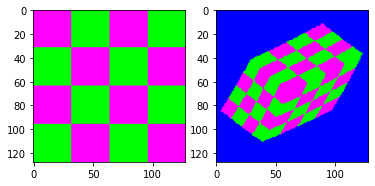

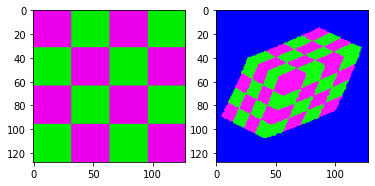

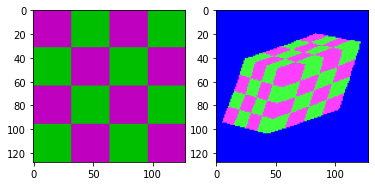

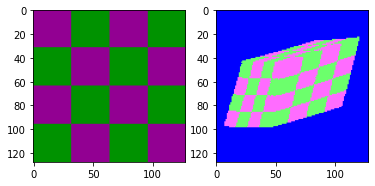

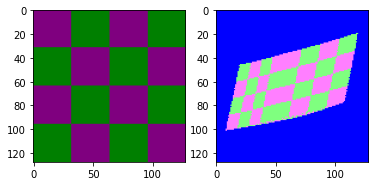

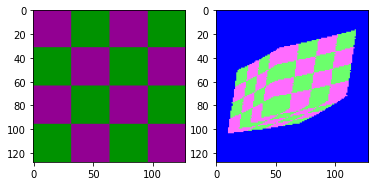

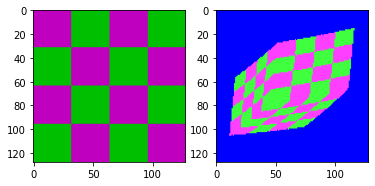

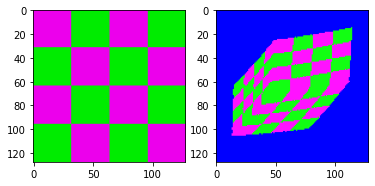

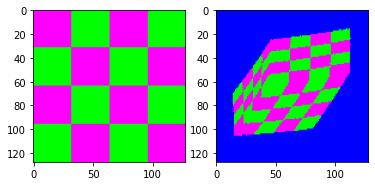

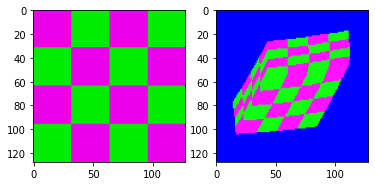

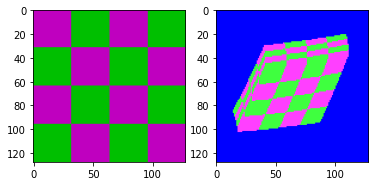

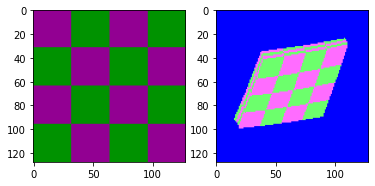

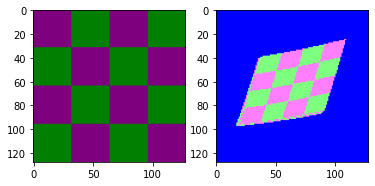

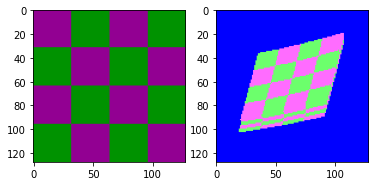

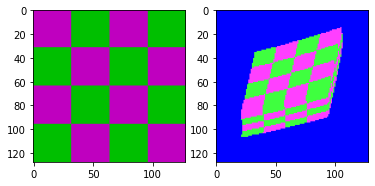

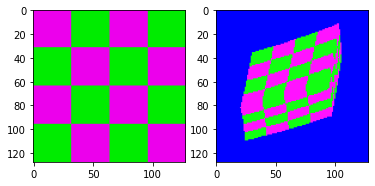

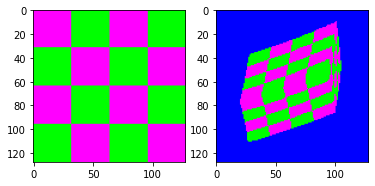

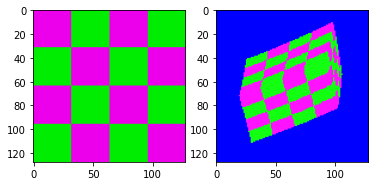

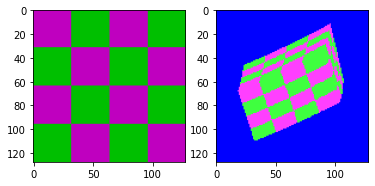

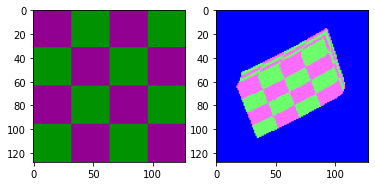

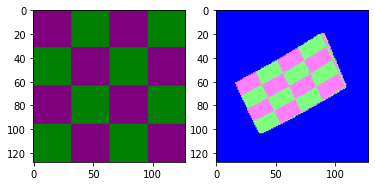

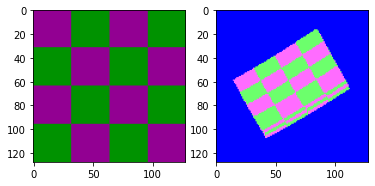

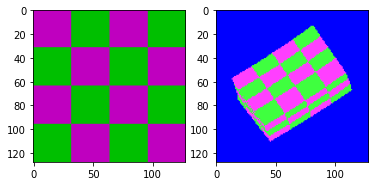

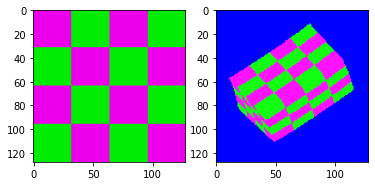

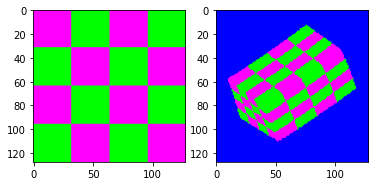

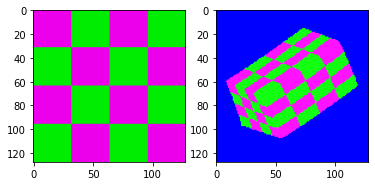

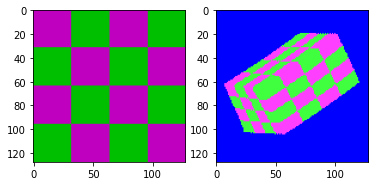

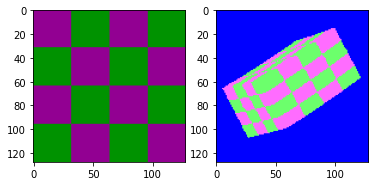

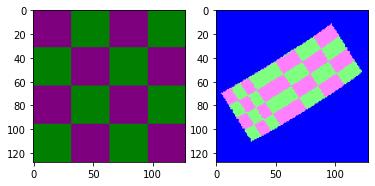

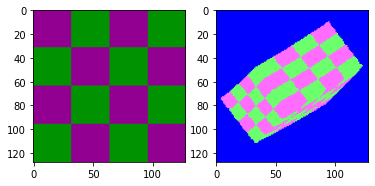

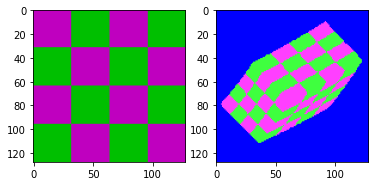

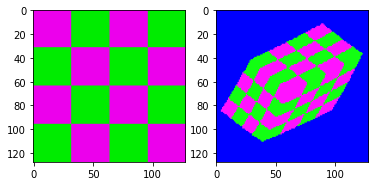

In [10]:
import pylab as pl

for x, y in zip(X_cpu, Y_cpu):
    for t in range(Y_cpu.shape[4]):
        pl.subplot(121)
        pl.imshow(ortho(x[:,:,:,t,:], empty_values))
        pl.subplot(122)
        pl.imshow(ortho(y[:,:,:,t,:], empty_values))
        pl.show()

In [11]:
# inspect the generated source code
print(jitaug.string)


# Copyright (c) 2020, NVIDIA CORPORATION.

# NOTE: this file was generated by a machine 

from numba import cuda
import math

@cuda.jit
def augment(batch_in, batch_out, empty_values, spatial_params1, spatial_params2, spatial_params3, color_params0):
    """fused augmentation kernel for SOL tensor manipulation"""

    # fix the dimensions of the input tensor in "channels last" order
    dimB_in = 0
    dimC_in = 5
    dimX_in = 1
    dimY_in = 2
    dimZ_in = 3
    dimT_in = 4

    # fix the dimensions of the output tensor in "channels last" order
    dimB_out = 0
    dimC_out = 5
    dimX_out = 1
    dimY_out = 2
    dimZ_out = 3
    dimT_out = 4

    # set starting indices of grid-stride loops    
    lowerB = 0 
    lowerC = 0
    lowerX = 0
    lowerY = cuda.blockIdx.z*cuda.blockDim.z+cuda.threadIdx.z
    lowerZ = cuda.blockIdx.y*cuda.blockDim.y+cuda.threadIdx.y
    lowerT = cuda.blockIdx.x*cuda.blockDim.x+cuda.threadIdx.x
    
    # set strides of grid-stride loops
    strideB = 1